## Import libraries

In [1]:
# basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn tools
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, SelectPercentile, mutual_info_classif
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN, BorderlineSMOTE, KMeansSMOTE, SMOTENC

## Reading data

In [2]:
tumor = pd.read_csv("primary_tumor.csv", sep=",")
print('Feature "degree-of-diffe" description: \n',tumor['degree_of_diffe'].value_counts())
tumor = tumor.sample(frac=1)
tumor = tumor.drop('degree_of_diffe', axis=1)

Feature "degree-of-diffe" description: 
 ?         155
poorly    100
well       57
fairly     27
Name: degree_of_diffe, dtype: int64


## Encoding 

In [3]:
def ohe (dataset, col, target_col): # "dataset" must be a pd.DataFrame, "col" must be an array of strings, #"target_col" is self explicatory
    enc = OneHotEncoder()
    t = enc.fit_transform(X=dataset[col], y=None).toarray()
    con = np.concatenate(enc.categories_)
    print('***** Performing One Hot Encoding ***** \n All attributes encoded: ', con, " \n Shape of the new layout: ", t.shape)    
    x = dataset[target_col]
    c = col + target_col
    dataset = dataset.drop(columns=c)
    enc_data = pd.DataFrame(t, columns=con)
    dataset_final = pd.concat([dataset, enc_data, x], axis=1)
    return dataset_final

tumor = tumor.replace(["yes","no"], [0, 1])

tumor.loc[tumor['sex'] == 'male', 'sex'] = 0
tumor.loc[tumor['sex'] == 'female', 'sex'] = 1

tumor.loc[tumor['binaryClass'] == 'N', 'binaryClass'] = 0
tumor.loc[tumor['binaryClass'] == 'P', 'binaryClass'] = 1

tumor.loc[tumor['age'] == '<30', 'age'] = 'age_<30'
tumor.loc[tumor['age'] == '30-59', 'age'] = 'age_30-59'
tumor.loc[tumor['age'] == '>=60', 'age'] = 'age_>=60'

tumor.loc[tumor['histologic_type'] == 'adeno', 'histologic_type'] = 'HS_adeno'
tumor.loc[tumor['histologic_type'] == 'anaplastic', 'histologic_type'] = 'HS_anaplastic'
tumor.loc[tumor['histologic_type'] == 'epidermoid', 'histologic_type'] = 'HS_epidermoid'

columns_to_encode = ["age", "histologic_type"]

tumor = ohe(tumor, columns_to_encode,['binaryClass'])

for i in range(len(tumor.columns)):
    tumor = tumor[tumor.iloc[:,i] != '?']
tumor = tumor.reset_index(drop=True)

tumor = tumor.replace(['?'], np.nan)

print('How many missing attributes: ',tumor.isnull().sum().sum())



***** Performing One Hot Encoding ***** 
 All attributes encoded:  ['age_30-59' 'age_<30' 'age_>=60' '?' 'HS_adeno' 'HS_anaplastic'
 'HS_epidermoid']  
 Shape of the new layout:  (339, 7)
How many missing attributes:  0


## Splitting data

In [4]:
X = tumor.drop('binaryClass', axis=1) # non target
y = tumor['binaryClass'] # target

X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.20, random_state=15)

## Imputing missing values

In [5]:
from sklearn.impute import SimpleImputer

#tumor = tumor.astype(int)
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit(X_train)


SimpleImputer()

## Oversampling

In [6]:
#Os =  SMOTE()
#Os = RandomOverSampler()
#X_train, y_train = Os.fit_resample(X_train, y_train)

## Performing a Grid Search (with cross-validation) for parameter tuning of Logistic Regression

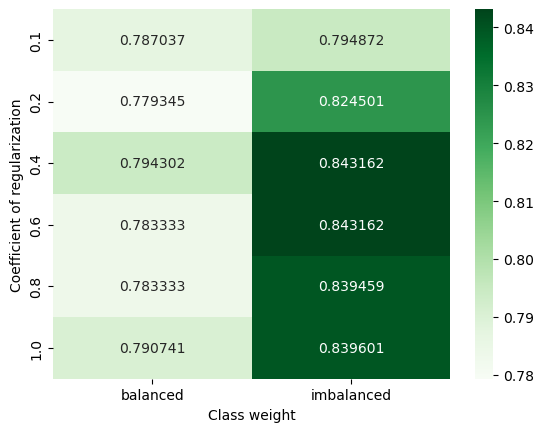

In [7]:
from sklearn.linear_model import LogisticRegression

a = [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
b = ['balanced', 'imbalanced']
param_grid = dict(C=a, class_weight=b)

clf = LogisticRegression()

grid = GridSearchCV(estimator=clf, param_grid=param_grid, cv=10)
grid.fit(X_train, y_train)
grid_results = pd.concat([pd.DataFrame(grid.cv_results_["params"]),pd.DataFrame(grid.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)
grid_contour = grid_results.groupby(['C','class_weight']).mean()
grid_reset = grid_contour.reset_index()
grid_reset.columns = ['Coefficient of regularization', 'Class weight', 'Accuracy']
grid_pivot = grid_reset.pivot('Coefficient of regularization', 'Class weight')
x = grid_pivot.columns.levels[1].values
y = grid_pivot.index.values
z = grid_pivot.values

fig = plt.gcf()

sns.heatmap(grid_pivot['Accuracy'],annot=True,cmap='Greens', fmt='g')

plt.show()
plt.draw()

fig.savefig('TUNEtumorLR.png', dpi=600)


## Logistic Regression and hold-out evaluation / Confusion matrix

              precision    recall  f1-score   support

           0       0.82      0.94      0.88        49
           1       0.75      0.47      0.58        19

    accuracy                           0.81        68
   macro avg       0.79      0.71      0.73        68
weighted avg       0.80      0.81      0.79        68

score:  0.8088235294117647


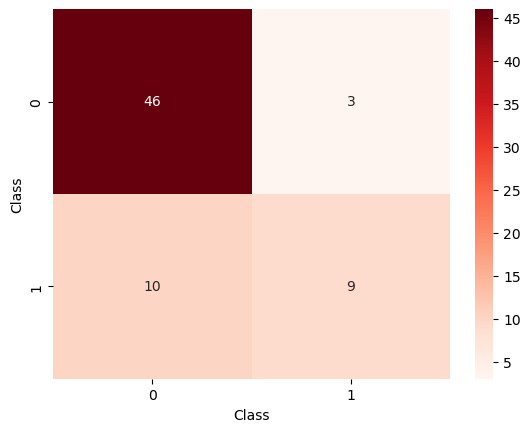

In [8]:
LR = LogisticRegression()

LR.fit(X_train, y_train)
y_pred = LR.predict(X_test)

#Evaluation
print(classification_report(y_test, y_pred, zero_division = 0))
print("score: ", LR.score(X_test, y_test))
M = confusion_matrix(y_test, y_pred)

fig = plt.gcf()

sns.heatmap(M,annot=True,cmap='Reds', fmt='g')
plt.xlabel('Class')
plt.ylabel('Class')

plt.show()
plt.draw()
fig.savefig('CMtumorLR.png', dpi=100)

## Performing a Grid Search (with cross-validation) for parameter tuning of k-NN

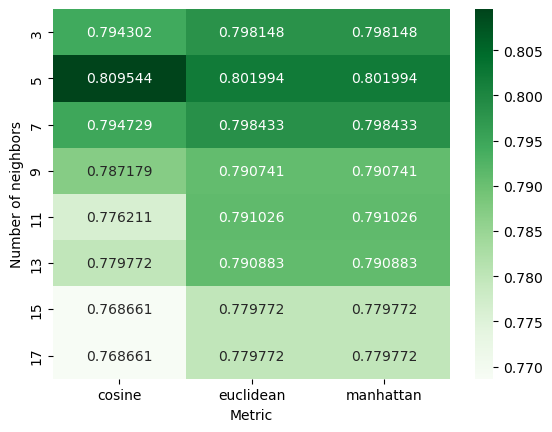

In [9]:
from sklearn.neighbors import KNeighborsClassifier

#a = ['uniform', 'distance']
a = ['manhattan', 'euclidean', 'cosine']
b = [3,5,7,9,11,13,15,17]
param_grid = dict(metric=a, n_neighbors=b)

clf = KNeighborsClassifier()

grid = GridSearchCV(estimator=clf, param_grid=param_grid, cv=10)
grid.fit(X_train, y_train)
grid_results = pd.concat([pd.DataFrame(grid.cv_results_["params"]),pd.DataFrame(grid.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)
grid_contour = grid_results.groupby(['n_neighbors','metric']).mean()
grid_reset = grid_contour.reset_index()
grid_reset.columns = ['Number of neighbors','Metric', 'Accuracy']
grid_pivot = grid_reset.pivot('Number of neighbors','Metric')
x = grid_pivot.columns.levels[1].values
y = grid_pivot.index.values
z = grid_pivot.values


fig = plt.gcf()

sns.heatmap(grid_pivot['Accuracy'],annot=True,cmap='Greens', fmt='g')

plt.show()
plt.draw()

fig.savefig('TUNEtumorkNN.png', dpi=100)


## Hold-out with best parameters of k-NN / Confusion matrix

              precision    recall  f1-score   support

           0       0.78      0.94      0.85        49
           1       0.67      0.32      0.43        19

    accuracy                           0.76        68
   macro avg       0.72      0.63      0.64        68
weighted avg       0.75      0.76      0.73        68

score:  0.7647058823529411


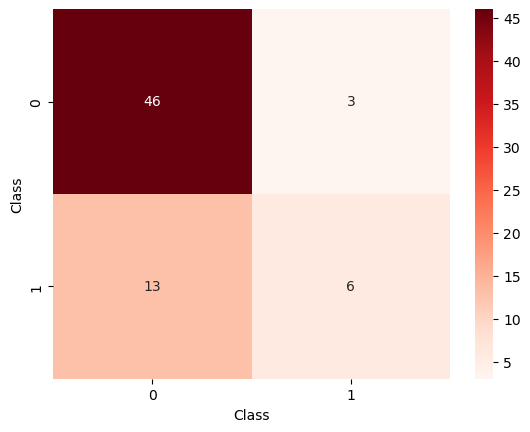

In [10]:
kNN = KNeighborsClassifier()

kNN.fit(X_train, y_train)
y_pred = kNN.predict(X_test)

#Evaluation
print(classification_report(y_test, y_pred, zero_division = 0))
print("score: ", kNN.score(X_test, y_test))
M = confusion_matrix(y_test, y_pred)

fig = plt.gcf()

sns.heatmap(M,annot=True,cmap='Reds', fmt='g')
plt.xlabel('Class')
plt.ylabel('Class')

plt.show()
plt.draw()
fig.savefig('CMtumorkNN.png', dpi=100)

## Performing a Grid Search (with cross-validation) for parameter tuning of SVC

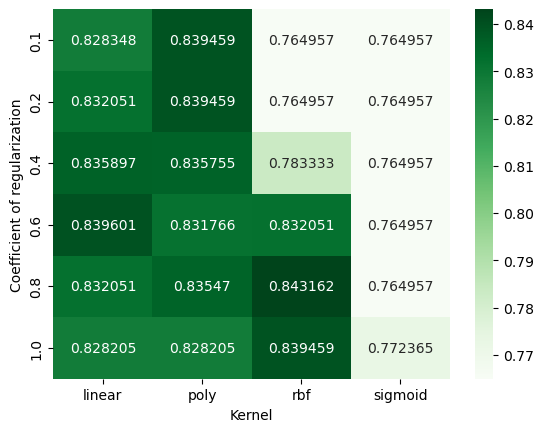

,C,kernel,Accuracy
0,0.1,linear,0.828348
1,0.1,rbf,0.764957
2,0.1,sigmoid,0.764957
3,0.1,poly,0.839459
4,0.2,linear,0.832051
5,0.2,rbf,0.764957
6,0.2,sigmoid,0.764957
7,0.2,poly,0.839459
8,0.4,linear,0.835897
9,0.4,rbf,0.783333


In [11]:
from sklearn.svm import SVC

c = [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
kernels = ['linear','rbf', 'sigmoid','poly']
param_grid = dict(C=c, kernel=kernels)

clf = SVC()

grid = GridSearchCV(estimator=clf, param_grid=param_grid, cv=10)
grid.fit(X_train, y_train)

grid_results = pd.concat([pd.DataFrame(grid.cv_results_["params"]),pd.DataFrame(grid.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)

grid_contour = grid_results.groupby(['C','kernel']).mean()
grid_reset = grid_contour.reset_index()
grid_reset.columns = ['Coefficient of regularization', 'Kernel', 'Accuracy']
grid_pivot = grid_reset.pivot('Coefficient of regularization', 'Kernel')
x = grid_pivot.columns.levels[1].values
y = grid_pivot.index.values
z = grid_pivot.values

fig = plt.gcf()

sns.heatmap(grid_pivot['Accuracy'],annot=True,cmap='Greens', fmt='g')

plt.show()
plt.draw()

fig.savefig('TUNEtumorSVM.png', dpi=100)

grid_results


## Hold-out with best parameters of SVC / Confusion matrix

              precision    recall  f1-score   support

           0       0.82      0.94      0.88        49
           1       0.75      0.47      0.58        19

    accuracy                           0.81        68
   macro avg       0.79      0.71      0.73        68
weighted avg       0.80      0.81      0.79        68

score:  0.8088235294117647


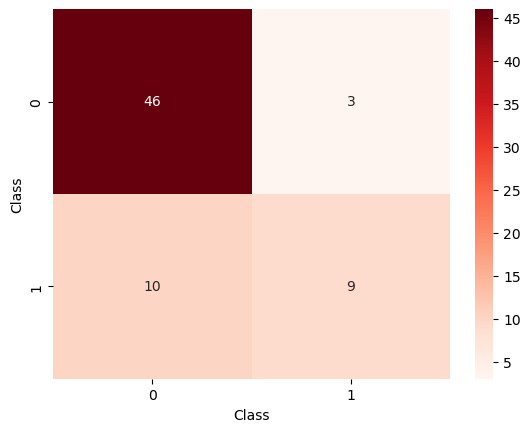

In [12]:
svm = SVC(kernel='linear', C=1.0)
#y_train =y_train.astype('int') 
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

#Evaluation
print(classification_report(y_test, y_pred, zero_division = 0))
print("score: ", svm.score(X_test, y_test))
M = confusion_matrix(y_test, y_pred)

fig = plt.gcf()

sns.heatmap(M,annot=True,cmap='Reds', fmt='g')
plt.xlabel('Class')
plt.ylabel('Class')

plt.show()
plt.draw()
fig.savefig('CMtumorSVM.png', dpi=100)